In [1]:
!pip install omnixai pillow<10.0


/bin/bash: ligne 1: 10.0: Aucun fichier ou dossier de ce nom


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
import matplotlib.pyplot as plt
import PIL
import gc

import urllib.request
import logging
import os

import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import cv2
from scipy.ndimage import filters
from torch import nn

import clip

from matplotlib.backends.backend_pdf import PdfPages
import torch.distributed as dist
from lavis.common.dist_utils import get_rank, get_world_size, is_main_process, is_dist_avail_and_initialized
from lavis.common.logger import MetricLogger, SmoothedValue
from lavis.common.registry import registry
from lavis.datasets.data_utils import prepare_sample
from lavis.models.clip_models.model import CLIP, load_state_dict, load_openai_model
from lavis.models.clip_models import tokenizer
from lavis.processors.clip_processors import ClipImageTrainProcessor
from lavis.processors.blip_processors import BlipCaptionProcessor
from transformers import CLIPProcessor, CLIPModel

from omnixai.data.text import Text
from omnixai.data.image import Image
from omnixai.data.multi_inputs import MultiInputs
from omnixai.preprocessing.image import Resize
from omnixai.explainers.vision_language.specific.gradcam import GradCAM

In [3]:
def load_Fmodel_clip(chekpoint=True, vit=True):
    preprocess=None
    if vit:
        model_cfg ={
            "embed_dim": 768,
            "quick_gelu": True,
            "vision_cfg": {
                "image_size": 336,
                "layers": 24,
                "width": 1024,
                "patch_size": 14
            },
            "text_cfg": {
                "context_length": 77,
                "vocab_size": 49408,
                "width": 768,
                "heads": 12,
                "layers": 12
            }
        }
        model = CLIP(**model_cfg)
        if chekpoint:
            checkpoint_path = "lavis/checkpoint_best (1).pth"
            model.load_state_dict(load_state_dict(checkpoint_path))
        _, preprocess = clip.load("ViT-L/14")
    else:
        model, preprocess = clip.load("RN50", device="cuda")
    del _
    return model, preprocess

In [4]:
def forward(model,dico):
    im,txt = dico['im'],dico['txt']
    txt_enc = BlipCaptionProcessor(max_words=77)(txt)
    txt_enc= model.tokenizer(txt_enc, add_cls_token=True)
    txt_enc,txt_enc_class=model.encode_text(txt_enc.to(dtype=torch.int64))
    txt_enc=F.normalize(txt_enc, dim=-1)

    image=ClipImageTrainProcessor(image_size=336)(im)
    feat_im = model.encode_image(image[None])
    feat_im =F.normalize(feat_im, dim=-1)
    del im,txt, txt_enc_class, image
    return txt_enc @ feat_im.T



In [5]:
def normalize(x: np.ndarray) -> np.ndarray:
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    del attn_map_c, cmap, blur
    return attn_map

def viz_attn(txt, attn_map, title="Carte de chaleur du texte"):
    if isinstance(txt, str):
        tokens = txt.split()[:77]
    else:
        tokens = txt

    attn_map = np.array(attn_map)
    
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.set_title(title, fontsize=14, pad=15)
    ax.axis("off")

    for i, token in enumerate(tokens):
        ax.text(
            i + 0.5, 0.5, token,  
            ha="center", va="center",
            fontsize=12,
            bbox=dict(
                facecolor=plt.cm.Reds(attn_map[i]), 
                edgecolor="none", boxstyle="round,pad=0.3"
            )
        )

    ax.set_xlim(0, len(tokens))
    ax.set_ylim(0, 1)

    pdf.savefig(fig)
    plt.close(fig)

    
def load_image(img_path, resize=None):
    image = PIL.Image.open(img_path).convert("RGB")
    if resize is not None:
        image = image.resize((resize, resize))
    del resize
    return np.asarray(image).astype(np.float32) / 255.

In [6]:
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

In [7]:
import cv2 
import numpy as np 

class GradCamViT:
    def __init__(self, model, target, height=24):
        self.model = model.eval() 
        self.feature = None 
        self.gradient = None  
        self.handlers = []  
        self.target = target
        self._get_hook() 
        self.height=height

    def _get_features_hook(self, module, input, output):
        if isinstance(output, tuple):
            output=output[0]
        self.feature = self.reshape_transform(output) 

    def _get_grads_hook(self, module, input_grad, output_grad):
        if isinstance(output_grad, tuple):
            output_grad=output_grad[0]
        self.gradient = self.reshape_transform(output_grad)  

        def _store_grad(grad):
            self.gradient = self.reshape_transform(grad)  

    #output_grad.register_hook(_store_grad) 

    def _get_hook(self):
        self.target.register_forward_hook(self._get_features_hook)
        self.target.register_forward_hook(self._get_grads_hook)

    def reshape_transform(self, tensor):
        if tensor.shape[1]==1:
            tensor = tensor.permute(1, 0, 2)
        print(1,24,24,768, tensor.shape)
        result=tensor[:, :, :]
        #result = tensor[:, 1:, :].reshape(tensor.size(0), self.height, self.height, tensor.size(2))
        #result = result.transpose(2, 3).transpose(1, 2)  
        return result

    def __call__(self, inputs, val, index):
        self.model.zero_grad()
        if True:
            image=inputs["im"]
            text=inputs["txt"]
            self.model.eval()
            image_features = self.model.visual(image)
            image_features_norm = image_features.norm(dim=-1, keepdim=True)
            image_features_new = image_features / image_features_norm

            x = self.model.token_embedding(text)  # [batch_size, n_ctx, d_model]
            x = x + self.model.positional_embedding
            x = x.permute(1, 0, 2) 
            x = self.model.transformer(x, attn_mask=self.model.attn_mask)
            x = x.permute(1, 0, 2) 
    
            x = self.model.ln_final(x)
            target_features = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.model.text_projection
            
            target_features_norm = target_features.norm(dim=-1, keepdim=True)
            target_features_new = target_features / target_features_norm
            similarity = image_features[0].dot(target_features[0])
            self.model.zero_grad()
            similarity.backward(retain_graph=True)
            
            txt_attn_blocks = list(dict(self.model.transformer.resblocks.named_children()).values())
            num_tokens = txt_attn_blocks[0].attn_probs.shape[-1]

            
            cam = txt_attn_blocks[-1].attn_grad.detach()
                
            cam = cam.mean(dim=0) #577,577 77,77
            image_relevance = cam[index,:]
            image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
            cam=image_relevance
            print(cam)
            return cam.cpu().data.numpy()


        #textes=inputs["txt"]
        #produit=[]
        #for t in textes:
        #    inputs["txt"]=t
        #    produit.append(forward(self.model,inputs))
        #print("dfghj")
        #prod=torch.tensor(produit)
        #print("dfghj")
        #target=F.softmax(prod, dim=0)
        #print(target.shape)
        #output = forward(inputs)  

        #index = np.argmax(output.cpu().data.numpy())
        #target = output[0][index]  

        gradient = self.gradient[0].permute(1, 0).cpu().data.numpy()
        weight = np.mean(gradient, axis=(1)) 
        feature = self.feature[0].permute(1, 0).cpu().data.numpy()
        
        cam = feature * weight[:, np.newaxis]
        cam = np.sum(cam, axis=0)  
        cam = np.maximum(cam, 0)  

        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam  # Return the Grad-CAM heat map
        

In [8]:
def gradCAMResnet(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    if input.grad is not None:
        input.grad.data.zero_()
        
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)
        
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:        
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()
    
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        gradcam = torch.clamp(gradcam, min=0)

    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)
    
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
        
    return gradcam

Résultat pour la phrase complète :
1 24 24 768 torch.Size([1, 77, 768])
1 24 24 768 torch.Size([1, 77, 768])
tensor([0.0000, 0.1438, 0.0954, 0.2599, 0.7147, 0.2626, 0.3060, 0.5939, 0.2961,
        0.4656, 0.5097, 0.7202, 0.5928, 0.7509, 0.3669, 0.8145, 0.3341, 0.4665,
        0.2222, 0.5236, 0.0490, 0.2358, 0.3729, 0.7918, 0.5296, 0.7661, 0.6673,
        0.5002, 0.5563, 1.0000, 0.4116, 0.5212, 0.5301, 0.4417, 0.3617, 0.4403,
        0.4596, 0.4644, 0.6115, 0.4557, 0.4468, 0.6204, 0.6454, 0.3956, 0.4464,
        0.3773, 0.2947, 0.3628, 0.3993, 0.3898, 0.4772, 0.4332, 0.4281, 0.4676,
        0.3975, 0.3492, 0.3117, 0.2860, 0.2562, 0.2322, 0.2893, 0.3558, 0.3769,
        0.2524, 0.2845, 0.2864, 0.3930, 0.2611, 0.4070, 0.4512, 0.2185, 0.2537,
        0.1796, 0.3220, 0.1355, 0.1678, 0.3589])


/tmp/ipykernel_59443/128163509.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)


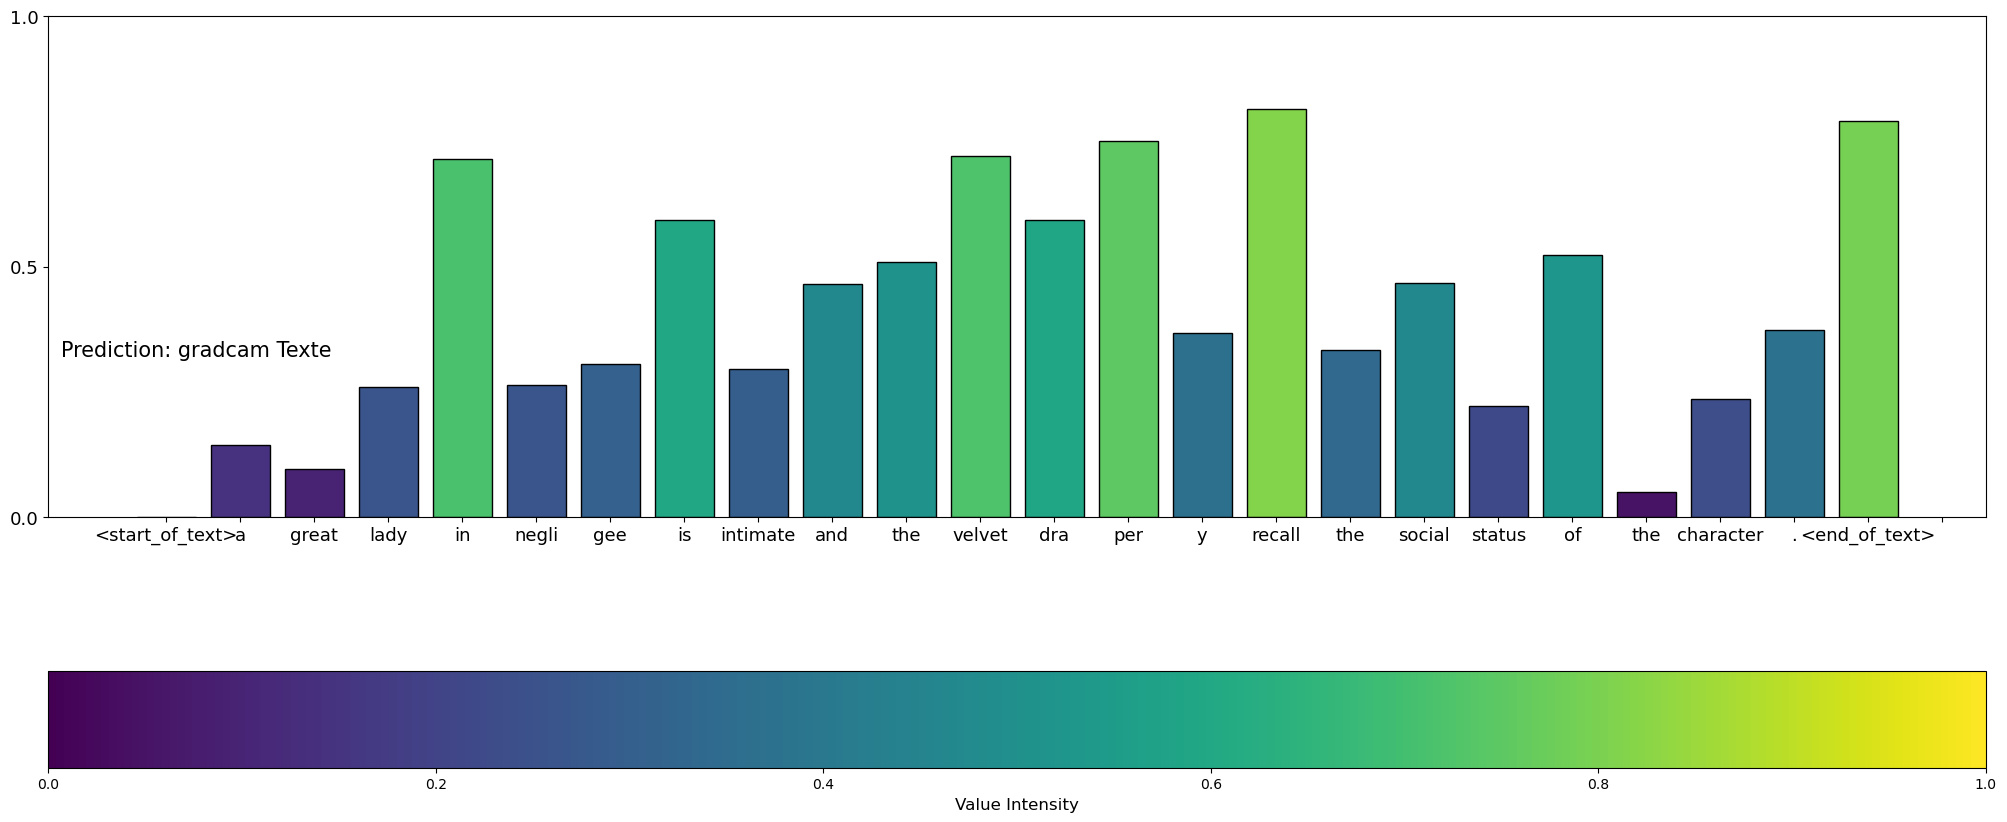

In [9]:
def _plot_score(vec, pred_text, xticks):
    xticks=xticks[:xticks.index('<end_of_text>')+1]
    vec=vec[:len(xticks)]
    _axis_fontsize=13
    fig=plt.figure(figsize = (len(vec)+1,10))

    colors = plt.cm.viridis(vec)
    plt.bar(range(len(vec)), vec, color=colors, edgecolor='black', align='center')

    #plt.yticks([])
    plt.yticks([0, 0.5, 1], fontsize=_axis_fontsize)
    plt.xticks(range(0,len(vec)+1), xticks+[" "], fontsize=_axis_fontsize)
    #fig.add_subplot(1, 1, 1)
    #plt.figtext(x=0.13, y=0.54, s='Prediction: {}'.format(pred_text), fontsize=15, fontname='sans-serif')
    #img = plt.imshow([vec], vmin=0, vmax=1)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='horizontal', pad=0.2)
    cbar.set_label('Value Intensity', fontsize=12)
    
    plt.figtext(x=0.13, y=0.54, s='Prediction: {}'.format(pred_text), fontsize=15, fontname='sans-serif')


    plt.show()
    

    
def lancerCode(vit, chekpoint, im, txt, image_path, title):
    model,preprocess=load_Fmodel_clip(chekpoint=chekpoint, vit=vit)
    #if vit and chekpoint:
    #    cam=GradCamViT(model, model.transformer.resblocks[-1])({"im":im,"txt":txt[0]}, chekpoint)
    #    #viz_attn(txt, cam, title)
    #    print(cam)
    #    _plot_score(vec=cam, pred_text=txt, xticks=_get_text_xticks(txt))
    if vit:
        image = ClipImageTrainProcessor(image_size=336)(im).unsqueeze(0)
        model.add_cls_token=False
        text = clip.tokenize(txt)
        textDetoken=""
        for token in text.tolist()[0]:
            tokenDetoken = tokenizer._tokenizer.decode([token])
            textDetoken+= "<\w>"+ tokenDetoken
        xticks=_get_text_xticks(textDetoken[len("<\w>"):])
        cam=GradCamViT(model, model.transformer.resblocks[-1], height=24)({"im":image,"txt":text}, chekpoint, xticks.index('<end_of_text>'))
        
        _plot_score(vec=cam, pred_text="gradcam Texte", xticks=xticks)
    else:
        image, text=pre_forward_resnet(model,{"im":im,"txt":txt}, preprocess)
        cam=gradCAMResnet(model.visual,image,text,getattr(model.visual, "layer4"))
        cam = cam.squeeze().detach().cpu().numpy()
        #viz_attn(txt, cam, title)
    return cam

image_path="image/imageFC.png"#"image.jpg"
image=PIL.Image.open(image_path)

im = image#"They are framed by columns, and are looking towards the detailed city and landscape in the background."#,"The Descent from the Cross (or Deposition of Christ, or Descent of Christ from the Cross) is a panel painting by the Flemish artist Rogier van der Weyden created c. 1435, now in the Museo del Prado, Madrid."]

#cam1, image = lancerCode(True, True, im, "Subleyras’s female portraits are recognizable by the round, youthful faces of the models, a characteristic attributed here to Countess Mahony.", image_path)
#cam2, image = lancerCode(True, False, im, "Subleyras’s female portraits are recognizable by the round, youthful faces of the models, a characteristic attributed here to Countess Mahony.", image_path)
#afficheDiff(cam1,cam2, image)

phrase = "A great lady in negligee is intimate and the velvet drapery recall the social status of the character."

mots = phrase.split()

vit = True
chekpoint= False
with PdfPages("clipTest.pdf") as pdf:
    print("Résultat pour la phrase complète :")
    cam_phrase = lancerCode(vit, chekpoint, im, phrase, image_path, baton)
